In [35]:
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker as mticker
from mpl_finance import candlestick_ohlc
from matplotlib import style
from matplotlib.dates import date2num       
%matplotlib inline

In [36]:
from sklearn import preprocessing
import math
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection

In [163]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [69]:
import pandas as pd
from pandas_datareader import data
import numpy as np
from datetime import date, timedelta, datetime
import requests
from newsapi import NewsApiClient
from keras.models import load_model
import json


Using TensorFlow backend.


In [222]:
# Taking articels which contain the requested companys for sentiment analysis - extra feature
def getting_news(stock_name = "google"):
    
    stock_name = stock_name.lower()
    model = load_model('model.h5')
    newsapi = NewsApiClient(api_key='58fbbd40ab64422889ce36d19280078f')

    news = newsapi.get_everything(q=stock_name,
                                          sources='financial-post,cnbc',
                                          domains='business.financialpost.com,cnbc.com',
                                          from_param='2020-01-15',
                                          to='2020-01-23',
                                          language='en',
                                          sort_by='relevancy',
                                          page=2)
        # saving news as json

    articles = news["articles"]
    results = list()
    titles = list()

    # Iterate over all articles and extract title and content
    # Checking for duplicates by titles
    
    texts = list()
    i=0
    for ar in articles: 
        if ar["title"] not in titles:
            i+=1
            titles.append(ar["title"])
            if ar["description"] is not None:
                texts.append(ar["description"])
    
    tk = Tokenizer()
    tk.fit_on_texts(texts)
    index_list = tk.texts_to_sequences(texts)
    X = pad_sequences(index_list, maxlen=356)
    X = X/2
    score = model.predict(X)
    return sum(score)


In [235]:

def moving_average(values, window):
    weights = np.repeat(1.0, window)/window
    smas = np.convolve(values, weights, "valid")
    return smas

def high_minus_low(highs, lows):
    return highs-lows

# Graph information
def graph_data(stock, name):
    %matplotlib notebook

    style.use("seaborn")    
    
    MA1 = 10
    MA2 = 30
    highs = []
    lows = []
    volume = []
    sdate = []
    sclose = []
    stock_name = name # gettin the name in the first row of names

    for date in stock["Date"]: # insert the dates as string to pdate list
        pdate = datetime(year=date.year, month=date.month, day=date.day)
        sdate.append(pdate)
    for price in stock["Close"]: # insert the colsing prices for each date
        sclose.append(price)
    for high in stock["High"]: # insert the colsing prices for each date
        highs.append(high)
    for low in stock["Low"]: # insert the colsing prices for each date
        lows.append(low)
    for vol in stock["Volume"]: # insert the colsing prices for each date
        volume.append(vol)
        
    m1 = moving_average(sclose, MA1)    
    m2 = moving_average(sclose, MA2)    
    start = len(sdate[MA2-1:])
    
    h_l = list(map(high_minus_low, highs, lows))
    
    #figurs config:
    fig = plt.figure(facecolor = "#f0f0f0")
    ax1 = plt.subplot2grid((6,1),(0,0),rowspan=1,colspan=1)
    plt.title(f"{stock_name} chart")
    plt.ylabel("H-L")
    ax2 = plt.subplot2grid((6,1),(1,0),rowspan=4,colspan=1, sharex=ax1)
    plt.ylabel("Price")
    ax2v = ax2.twinx() #share the same x with differnt y's on the side
    ax3 = plt.subplot2grid((6,1),(5,0),rowspan=1,colspan=1, sharex=ax1)
    plt.ylabel("MAvgs")
    
    ax1.plot_date(sdate[-start:],h_l[-start:],"-",linewidth = 1, label="H-L")
    ax1.yaxis.set_major_locator(mticker.MaxNLocator(nbins=3, prune = "lower")) #how many labels we will see
    
    
    x=0
    y=len(stock["Date"])
    ohlc = []
    dfdate = stock["Date"].apply(date2num)    
    while x < y:
        append_me = dfdate.iloc[x], stock["Open"].iloc[x], stock["Close"].iloc[x], stock["High"].iloc[x], stock["Low"].iloc[x],...
        stock["Volume"].iloc[x], stock["Date"].iloc[x]
        ohlc.append(append_me)
        x+=1    
        
    # Making candlestick graph
    candlestick_ohlc(ax2, ohlc, width=0.4, colorup="#77d879", colordown="#db3f3f")
    myFmt = mdates.DateFormatter('%Y-%m-%d')
    ax2.xaxis.set_major_formatter(myFmt)


    ax2.yaxis.set_major_locator(mticker.MaxNLocator(nbins=7, prune = "upper")) #how many labels we will see

    ax2v.plot([],[],linewidth=5, label = "Volume", color = "#0079a3", alpha = 0.4)
    ax2v.fill_between(sdate[-start:], 0, volume[-start:], facecolor = "#0079a3", alpha = 0.4)
    ax2v.axes.yaxis.set_ticklabels([])
    ax2v.grid(False)
    ax2v.set_ylim(0.3, max(volume)) #keeping the volume low in the graph
    
    # annotate current price
    bbox_props = dict(boxstyle="round", fc="w", ec="k", lw=1)      
    ax2.annotate(str(sclose[-1]), (sdate[-1] ,sclose[-1]), xytext=(1.05,0.5), textcoords="axes fraction",
                 bbox=bbox_props)

    ax2.text(sdate[10], sclose[int((len(sclose))/2)], f"\n{stock_name} Stock Graph")    
    
    #ax3:
    ax3.plot([],[],linewidth=5, label = f"{MA1} MS")
    ax3.plot([],[],linewidth=5, label = f"{MA2} MS")
    ax3.plot(sdate[-start:], m1[-start:], linewidth = 1)
    ax3.plot(sdate[-start:], m2[-start:], linewidth = 1)
    ax3.yaxis.set_major_locator(mticker.MaxNLocator(nbins=3, prune = "upper")) #how many labels we will see
    ax3.fill_between(sdate[-start:], m2[-start:], m1[-start:], where=(m1[-start:] < m2[-start:]),
                     facecolor = "r", alpha = 0.5)
    ax3.fill_between(sdate[-start:], m2[-start:], m1[-start:], where=(m1[-start:] > m2[-start:]),
                     facecolor = "g", alpha = 0.5)
    for label in ax3.xaxis.get_ticklabels():
        label.set_rotation(45)
    
    
    plt.setp(ax1.get_xticklabels(), visible=False) #configure labels only in buttom
    plt.setp(ax2.get_xticklabels(), visible=False) #configure labels only in buttom

    ax1.legend()
    leg = ax1.legend(loc="upper right", ncol=2, prop={"size":11})
    leg.get_frame().set_alpha(0.4)
    ax2v.legend()
    leg = ax2v.legend(loc="upper right", ncol=2, prop={"size":11})
    leg.get_frame().set_alpha(0.4)
    ax3.legend()
    leg = ax3.legend(loc="upper right", ncol=2, prop={"size":11})
    leg.get_frame().set_alpha(0.4)
    
    plt.grid(True)
    plt.show()

    
    

In [236]:
def prediction(stock, name = "google"):
    
    style.use("dark_background")
     
    # Plot data about the asked stock
    graph_data(stock,name)
    # Getting score of news of recent days
    news_score = (getting_news(name)/2)
    # Making features
    dates = []
    cl_prices = []
    df = stock[["Open", "Close", "Low", "High", "Volume","Adj Close"]]
    df["NEWS-SCORE"] = 0
    for i in range(1,10):
        df["NEWS-SCORE"].iloc[-i] = news_score
    df["MOVING-AVG-9"] = df["Close"].rolling(9).mean().shift(-1)
    df["MOVING-AVG-28"] = df["Close"].rolling(28).mean()
    df["1DAY"] = df["Open"]- df['Open'].shift(1)
    df["HL_PCT"] = ((df["High"]-df["Low"])/df["Low"])*100
    df["PCT_Change"] = ((df["Close"]-df["Open"])/df["Open"])*100
    df["Final_Price"] = ((df["Close"]/df["Open"])-1)
    
    # Make it valid 'final_Price' label for logistic regression
    for key, value in df["Final_Price"].iteritems(): 
        if value > 0:
            df["Final_Price"].loc[key] = 1
        else:
            df["Final_Price"].loc[key] = -1
        
    df = df[["Close","HL_PCT","PCT_Change","Volume","1DAY","Final_Price","MOVING-AVG-9","MOVING-AVG-28"]]
    
    forcast_col = "Final_Price"
    
    df.fillna(-99999, inplace=True)

    forcast_out = int(math.ceil(0.1*len(df))) # Keeping 10 precent as stick without labels
    df["label"] = df[forcast_col].shift(-forcast_out)
    
    # in y we will save the lables so:
    y = np.array(df["label"])
    y = y[:-forcast_out]

    # making the X only the unshifted data (withot any new labels)
    X = np.array(df.drop(["label"], 1))
    X = preprocessing.scale(X)  # Scaling x (Normalize)
    X_lately = X[-forcast_out:]  # saving the info that we dont have y values for
    X = X[:-forcast_out]
    df.dropna(inplace=True)  # drop the unusful data before insert to y
    # here we will make the shuffle to X and y for spliting data to train and test
    # with using only the values in x and y, in this exemple were checking if the closing price is match
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

    # Using logistic regression model and using all of the data set
    # Using X_lately as test 
    
    model = LogisticRegression()
    model.fit(X_train, y_train)  # making the regression

    # check the accuracy by precent (directional most times)
    accuracy = model.score(X_test, y_test)
    
    forcast_set = model.predict(X_lately)  # predicting the result of X_lately (new stockes)
    
    for date in stock["Date"]: # insert the dates as string to pdate list
        pdate = datetime(year=date.year, month=date.month, day=date.day)
        dates.append(pdate)
    for price in df[forcast_col]: # insert the colsing prices for each date
        cl_prices.append(price)
    
    # Plot stragety
    df['Predicted_Signal'] = model.predict(X)
    df['Nifty_returns'] = np.log(df['Close']/df['Close'].shift(1))
    Cumulative_Nifty_returns = np.cumsum(df[int(math.ceil(0.1*len(df))):]['Nifty_returns'])
    df['Startegy_returns'] = df['Nifty_returns']* df['Predicted_Signal'].shift(1)
    Cumulative_Strategy_returns = np.cumsum(df[int(math.ceil(0.1*len(df))):]['Startegy_returns'])
    plt.figure(figsize=(10,5))
    plt.plot(Cumulative_Nifty_returns, color='r',label = 'Nifty Returns')
    plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
    plt.legend()
    plt.show()
    
    print("Accuracy: ")
    print(accuracy)

In [237]:
def start_forcaste(name='GOOGL', start_date='2019-08-23'):
    df = data.get_data_yahoo('GOOGL', '2019-04-23')
    df.reset_index(inplace=True,drop=False)
    prediction(df,name)

<IPython.core.display.Javascript object>


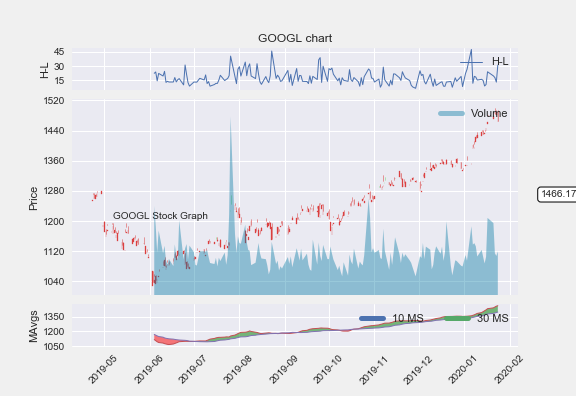

C:\Users\Daniel\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<IPython.core.display.Javascript object>


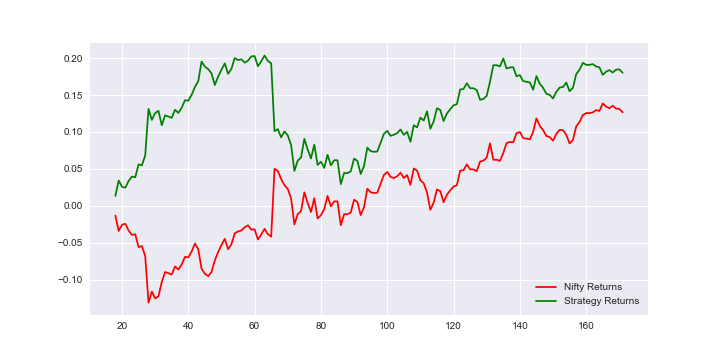

Accuracy: 
0.5714285714285714


In [238]:
start_forcaste()